# Analysis Notebook

In [389]:
import pandas as pd
import os
import operator

#os.chdir("/Users/bencampbell/code_louisville/capstone/louisville-bike-accidents/")

DATAPATH = "data/clean/bike_accidents.csv"
assert os.path.exists(DATAPATH)

DATA = DATA = pd.read_csv(DATAPATH)


In [390]:
# Adding some useful columns and defining some functions for use later in this notebook.

# New Columns
# Boolean value: True -> Casualty (injury or fatality); False -> Noncasualty
DATA['casualty_indicator'] = DATA['fatality_indicator'] | DATA['injury_indicator']
DATA['noncasualty_indicator'] = ~(DATA['fatality_indicator'] | DATA['injury_indicator'])

# Some roadways have a number but no name. Combine these values into a single column. 
# roadway name if any else roadway number. 
DATA['main_roadway'] = DATA['roadway_name'].combine_first(DATA['roadway_number'])
DATA['intersection_roadway'] = DATA['intersection_roadway_name'].combine_first(DATA['intersection_roadway_number'])

# Boolean value: True -> accident occurred in an intersection / between streets
DATA['intersection_indicator'] = DATA['intersection_roadway'].notnull()
DATA['between_street_indicator'] = (
    DATA['between_street_name_1'].notnull() | DATA['between_street_name_2'].notnull() | 
    DATA['between_street_number_1'].notnull() | DATA['between_street_number_2'].notnull())

#DATA.columns

In [391]:


# Useful function definitions / constants
TOTAL_ACCIDENTS = len(DATA) # Total number of accident reports
DANGERMASK = ['fatality_indicator', 'injury_indicator', 'casualty_indicator', 'noncasualty_indicator' ]
# This will get used over and over to analyse relative frequencies of crash outcomes.

def percent_round(x):
    """Create a readable percentage float using round()"""
    return round(x*100, 2)

def percent_format(x):
    """Format a number as a percentage."""
    return format(x, ".2%")


class DangerReport(pd.DataFrame):
    @property
    def totals(df):
        return df['casualties'] + df['noncasualties']
    
    def get_ratio_by_total(df):
        return (df/TOTAL_ACCIDENTS).apply(percent_round)

    def get_ratio_by_value_total(df):
        #totals = df['casualties'] + df['noncasualties']
        return df.apply(lambda x:x/df.totals).apply(percent_round)
    
    def get_danger_ratios(df):
        """total accidents, percent casualty, percent fatality of casualty"""
        out = pd.DataFrame(index=df.index)
        out['total'] = df.totals
        out['percent casualty'] = out.total.combine(df.casualties, lambda T, C:C/T).apply(percent_round)
        out['pct fatality of casualty'] = df.casualties.combine(df.fatalities, lambda C, F:F/C).apply(percent_round)
        out['pct fatality of total'] = df.fatalities.combine(out.total, lambda F, T:F/T).apply(percent_round)
        return out

def get_danger_report(df, label):
    report = df.groupby(label)[DANGERMASK].sum()
    report = report.rename({"injury_indicator":'injuries', 
                          'fatality_indicator':'fatalities',
                          'casualty_indicator':'casualties',
                          'noncasualty_indicator':'noncasualties'}, axis=1)
    return DangerReport(report)

# There's a way to work this into the class definition but I'd rather not struggle with
# __init__ and __new__ definitions right now. 

# lines for testing.
get_danger_report(DATA, 'weather').get_danger_ratios()

,total,percent casualty,pct fatality of casualty,pct fatality of total
weather,,,,
BLOWING SAND/SOIL/DIRT/SNOW,1,100.00,0.00,0.00
CLEAR,1084,71.86,2.82,2.03
CLOUDY,213,72.30,5.19,3.76
FOG WITH RAIN,1,100.00,100.00,100.00
OTHER,2,50.00,0.00,0.00
RAINING,69,76.81,5.66,4.35
SNOWING,4,75.00,0.00,0.00


<Axes: xlabel='hour of day', ylabel='accident count'>

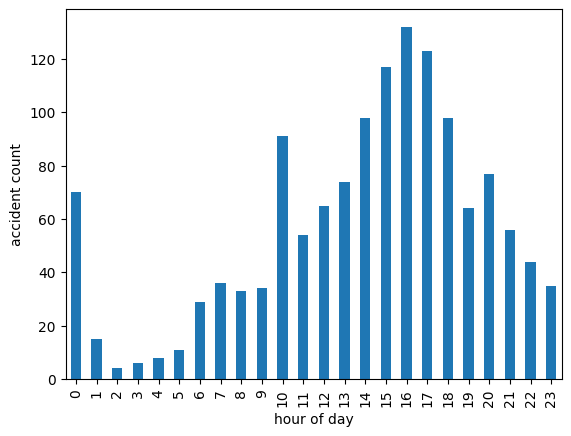

In [355]:
# Time of Day
# show sampling issue with dataset
DATA.groupby('hour').size().plot(kind='bar', xlabel='hour of day', ylabel="accident count")

<Axes: xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT'>

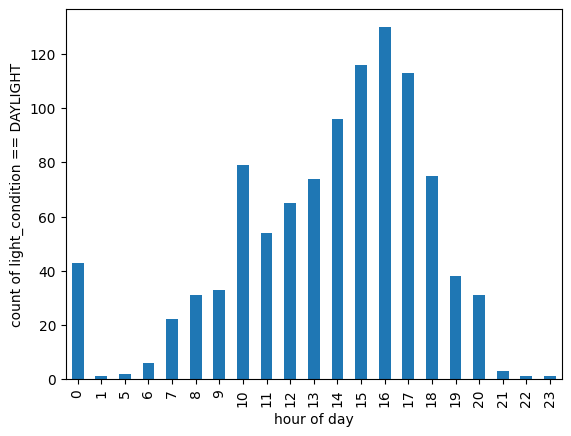

In [357]:
hour_light = DATA[['hour', 'light_condition']]
hour_light[hour_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT')

In [358]:
zeros = DATA[(DATA.hour==0) & (DATA.minute==0)]
# Get all rows that have 00:00 time value


#zeros[zeros['date'].apply(lambda x:x.second==0)]
# Check that the seconds are zero too.

zeros_index = zeros[zeros['light_condition'] == "DAYLIGHT"].index
# For recrods that have 00:00 time, find the ones that have light_condition == DAYLIGHT, 
# then filter these records out of my data:
zeros_index

Index([  31,   87,   95,   98,  101,  104,  109,  138,  171,  178,  189,  211,
        234,  334,  341,  349,  396,  479,  574,  578,  600,  602,  615,  670,
        709,  710,  711,  743,  786,  867,  882,  962,  979,  981,  997, 1045,
       1106, 1114, 1155, 1165, 1177, 1218],
      dtype='int64')

<Axes: xlabel='hour of day', ylabel='DAYLIGHT'>

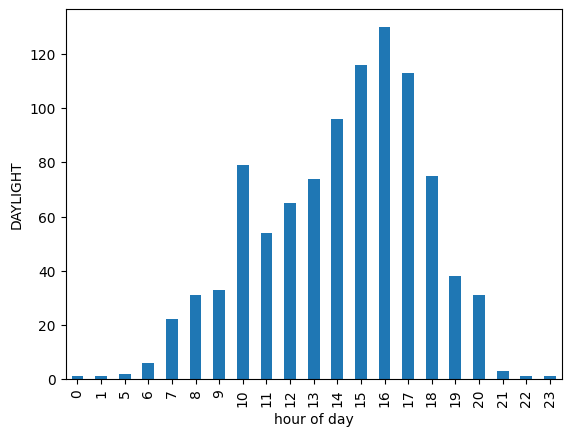

In [360]:
filtered_light = DATA[~DATA.index.isin(zeros_index)]
# Now let's see what the time distribution for DAYLIGHT condition looks like:
filtered_light[filtered_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', ylabel='DAYLIGHT', xlabel='hour of day')

In [385]:
#r = DangerReport(filtered_light.groupby('light_condition')[DANGERMASK].sum())
LC = get_danger_report(filtered_light, 'light_condition')
LC = LC.drop('OTHER', axis=0) 
# Only one record with value == OTHER. Dropping it since it's probably not significant.
LC.get_ratio_by_value_total().sort_values(by='noncasualties', ascending=False)

,fatalities,injuries,casualties,noncasualties
light_condition,,,,
DUSK,1.72,67.24,68.97,31.03
DAYLIGHT,1.34,69.14,70.37,29.63
DARK-HWY LIGHTED/ON,0.57,72.00,72.57,27.43
DAWN,0.00,74.19,74.19,25.81
DARK (UNKNOWN ROADWAY LIGHTING),0.00,85.71,85.71,14.29
DARK-HWY LIGHTED/OFF,7.69,80.77,88.46,11.54
DARK-HWY NOT LIGHTED,25.81,67.74,93.55,6.45


In [367]:
RC = get_danger_report(DATA, 'roadway_condition')
RC.get_danger_ratios()

,total,percent casualty,pct fatality of casualty,pct fatality of total
roadway_condition,,,,
DRY,1261,71.69,3.21,2.30
ICE,1,100.00,0.00,0.00
SNOW/SLUSH,4,75.00,0.00,0.00
WATER (STANDING OR MOVING),2,0.00,NaN,0.00
WET,106,79.25,5.95,4.72


In [386]:

RC_copy = RC.copy()
RC_copy.loc['WET'] = RC.iloc[1:].sum()
RC_copy = RC_copy.loc[['DRY', 'WET']]
RC_copy

,fatalities,injuries,casualties,noncasualties
roadway_condition,,,,
DRY,29,876,904,357
WET,5,83,88,25


In [387]:
RC_copy.get_ratio_by_value_total()
RC_copy.get_danger_ratios()[['percent casualty', 'pct fatality of casualty']]#.plot.pie(subplots=True)

,percent casualty,pct fatality of casualty
roadway_condition,,
DRY,71.69,3.21
WET,77.88,5.68


In [161]:
# Most dangerous roads?

#top_most_dangerous_roads = 
# Group by road type?
# Find percents by this: what percent of accidents occur in these most dangerous roads.
#top_most_dangerous_roads.plot(kind='bar', ylabel='value count')



<Axes: xlabel='main_roadway'>

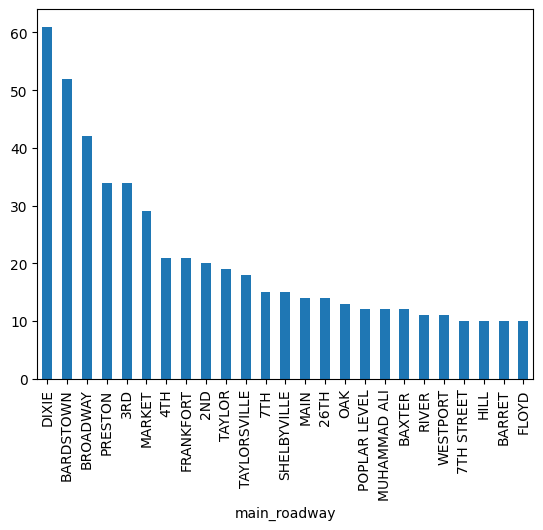

In [400]:
roadwaygroup = DATA.groupby(['main_roadway'])

roadwaygroup.size().sort_values(ascending=False).head(25).plot.bar()

In [406]:
roadwaygroup[DANGERMASK].sum().sort_values(by=['casualty_indicator'], ascending=False).head(25)

,fatality_indicator,injury_indicator,casualty_indicator,noncasualty_indicator
main_roadway,,,,
DIXIE,2,51,53,8
BROADWAY,0,30,30,12
BARDSTOWN,2,26,28,24
PRESTON,3,24,27,7
MARKET,0,19,19,10
TAYLORSVILLE,0,18,18,0
3RD,0,18,18,16
4TH,0,17,17,4
2ND,0,14,14,6


In [294]:
# Intersections vs non intersections and lighted intersections
